## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.


##### Questions:
1)	Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue. <br>
2)	Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue. 
##### Deliverables
3)	Score the ‘Test.csv’ using the model and select the best customers and share the customer ID’s as a csv file <br>
4)	Explain briefly the approach used in a separate document and also share the code that can be executed to reproduce results.


# Notebook 2: AB Testing
This notebook analyze the results of the experiment and answers 2 questions:
1) Did the promotion increase sales?
2) How much more is made (or lost) by sending out the promotion?


## Table of contents

- [Data gathering](#data)
- [Hypothesis test for Invariant Metric](#invariant)
- [Hypothesis test for IRR (Incremental Response Rate)](#IRR)
- [Hypothesis test for NIR (Net Incremental Revenue)](#NIR)
- [Summary](#summary)


In [1]:
# load in packages
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from src import Seafoam, config

%matplotlib inline

# font standardization
seafoam = Seafoam()

#suppress warnings
warnings.filterwarnings('ignore')

## Data Gathering <a name="data"></a> 

In [2]:
# load in the data
train_data = pd.read_csv(config.path_train_data)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044331,-0.385883,1,1,2,2


## Hypothesis test for Invariant Metric <a name="invariant"></a>

Make sure the control and treatment groups have features with the same distributions to avoid bias.
The number of customers that were offered promotions should be the same as those customers that did not receive the promotion.

In this case, we want to do a two-sided hypothesis test on the proportion of promotions assigned to one of our conditions.

Hypothesis to test:

### $H_0: P_{no promotions} = 0.5$
### $H_a: P_{no promotions} \neq 0.5$

In [3]:
# Split data into control and treatment groups
control_group = train_data.query('Promotion == "No"')
treatment_group = train_data.query('Promotion == "Yes"')

# drop promotion from treatment and control datasets as it's the split criteria
treatment_group = treatment_group.drop('Promotion', axis=1, errors='ignore')
control_group = control_group.drop('Promotion', axis=1, errors='ignore')
treatment_group.head()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,0,3,28.044331,-0.385883,1,1,2,2
8,15,0,2,31.930423,0.393317,2,3,1,2
10,17,0,1,32.770916,-1.511395,2,1,4,1
12,20,0,1,36.957009,0.133583,2,3,1,1
14,22,0,3,36.911714,-0.905350,2,2,4,1


In [4]:
total_observations = train_data.shape[0]
total_observations

84534

In [5]:
# total control group without promotions
c_obs = control_group.shape[0]
c_obs

42170

In [6]:
control_proportion = (control_group.shape[0] + 0.5)/total_observations
control_proportion

0.4988584474885845

In [7]:
# total treatment group with promotions
t_obs = treatment_group.shape[0]
t_obs

42364

In [8]:
# Now calculate the sample standard deviation under the null
# As we don't know population std, we calculate sample std but call it standard error
# Null hypothesis is 50%, thus 0.5
p = 0.5
standard_error = np.sqrt((p*(1-p)/total_observations))
standard_error

0.0017197063487546227

In [9]:
# formula for z score is sample mean - null mean / se
z = (control_proportion - p) / standard_error
z

-0.6638066506192764

In [10]:
# calculate the area under a normal curve (on calculator it is invnorm -999, -0.638, 0, 1)
p_value = stats.norm.cdf(z, 0, 1)*2
p_value

0.5068140685419098

In [11]:
# TODO
# feature distributions should be the same for all features
# use chi-squared test for categorical values and t-test for numerical features

### Conclusion

Even though there's a few hundred more customers received promotions in the treatment group than the control group, the difference between groups isn't statistically significant. We should feel fine about moving on to test the evaluation metrics.

Since P value > 0.05, we fail to reject the null hypothesis. It means that the number of customers in both groups is similar.

# Hypothesis test for IRR <a name="irr"></a>
#### Did the promotion increase sales?

Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue

Hypothesis to test:
### $H_0 = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} <= 0$ <br>
### $H_1 = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} > 0$

In [12]:
control_ratio = control_group.purchase.sum() / control_group.shape[0]
control_ratio

0.007564619397676073

In [13]:
treatment_ratio = treatment_group.purchase.sum() / treatment_group.shape[0]
treatment_ratio

0.017019167217448776

In [14]:
IRR = treatment_ratio - control_ratio
IRR

0.009454547819772702

In [15]:
control_group.purchase.sum()

319

In [16]:
# calculate the total purchase rate
combined_download_ratio = train_data.purchase.sum() / train_data.shape[0]
combined_download_ratio

0.012302742091939338

**Simulation Approach**

In [17]:
# bootstrap download rate
nr_trials = 10_000

irr_sample_distribution = []
for _ in range(nr_trials):
    boot_sample = train_data.sample(train_data.shape[0], replace=True)
    boot_control_group = boot_sample.query('Promotion == "No"')
    boot_treatment_group = boot_sample.query('Promotion == "Yes"')
    boot_control_ratio =   boot_control_group.purchase.sum() / control_group.shape[0]
    boot_treatment_ratio = boot_treatment_group.purchase.sum() / treatment_group.shape[0]
    irr = boot_treatment_ratio - boot_control_ratio
    irr_sample_distribution.append(irr)
    
irr_sample_distribution = np.array(irr_sample_distribution)
p_diff_mean = irr_sample_distribution.mean()
p_diff_std = irr_sample_distribution.std()
p_diff_std, p_diff_mean

(0.0007599607147401623, 0.009448828869044586)

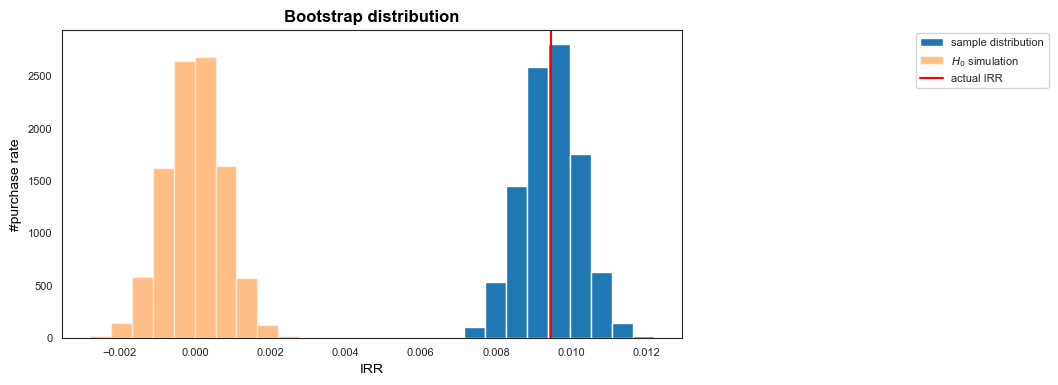

In [18]:
# Simulate the null when using sample distribution
null_vals = np.random.normal(0, irr_sample_distribution.std(), irr_sample_distribution.size)

plt.hist(irr_sample_distribution, label='sample distribution')
plt.hist(null_vals, alpha=0.5, label='$H_0$ simulation')
plt.axvline(IRR, color='r', label='actual IRR')
plt.xlabel('IRR')
plt.ylabel('#purchase rate')
plt.title('Bootstrap distribution')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [19]:
# probability to observe again the population proportion using nulls in a 2 sided z test
p_value = (null_vals > irr).mean()
p_value

0.0

**Analytical Approach**

In [20]:
se = np.sqrt((combined_download_ratio * (1-combined_download_ratio)/t_obs) + (combined_download_ratio * (1-combined_download_ratio)/c_obs))
se

0.00075827775128664

In [21]:
z = (treatment_ratio - control_ratio) / se
z

12.468449461599388

In [22]:
p_value = round(1 - stats.norm.cdf(z, 0, 1),4)
p_value

0.0

### Conclusion of IRR

Since P is less than 0.05, we reject the null hypothesis. The difference of 0.9% in IRR is significant and could not have come from the null. Promotions have a positive effect on sales.

# Hypothesis test for NIR (Net Incremental Revenue) <a name="nir"></a>
#### How much is made (or lost) by sending out the promotion?

$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$

Hypothesis to test:
### $H_0 = NIR <= 0 $
### $H_1 = NIR > 0 $



In [23]:
# Actual observation from the supplied experiment data
def nrr(control, treatment):
    nir = ((10 * treatment.purchase.sum()) -
           (0.15 * len(treatment)) -
           (10 * control.purchase.sum()))
    return nir

In [28]:
NIR = nrr(control_group, treatment_group)
NIR

-2334.5999999999995

In [25]:
# bootstrap NIR
nr_trials = 10_000
nr_samples = 20_000

nir_sample_distribution = []
for _ in range(nr_trials):
    boot_sample = train_data.sample(train_data.shape[0], replace=True)
    boot_control_group = boot_sample.query('Promotion == "No"')
    boot_treatment_group = boot_sample.query('Promotion == "Yes"')
    boot_nir = nrr(boot_control_group, boot_treatment_group)
    nir_sample_distribution.append(boot_nir)
    
nir_sample_distribution = np.array(nir_sample_distribution)
nir_mean = nir_sample_distribution.mean()
nir_std = nir_sample_distribution.std()
nir_std, nir_mean


(321.96702329588345, -2338.080195)

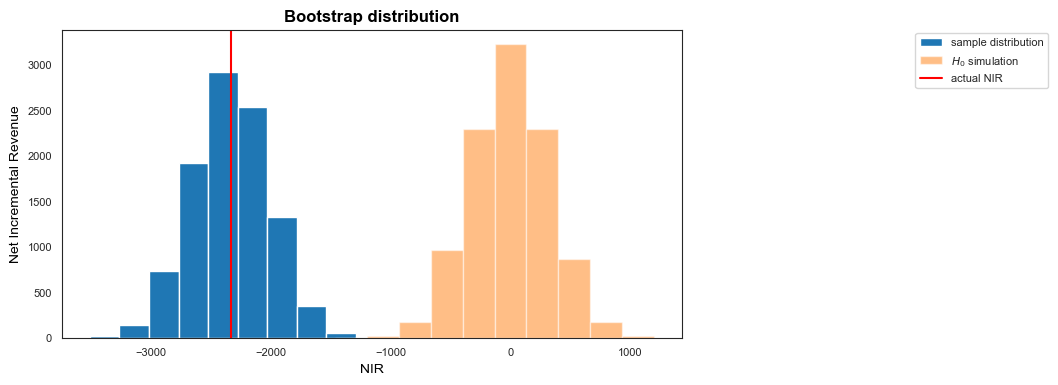

In [26]:
# Simulate the null when using sample distribution
null_vals = np.random.normal(0, nir_sample_distribution.std(), nir_sample_distribution.size)

plt.hist(nir_sample_distribution, label='sample distribution')
plt.hist(null_vals, alpha=0.5, label='$H_0$ simulation')
plt.axvline(NIR, color='r', label='actual NIR')
plt.xlabel('NIR')
plt.ylabel('Net Incremental Revenue')
plt.title('Bootstrap distribution')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [27]:
# probability to observe again the population proportion using nulls in a 2 sided z test
p_value = (null_vals > NIR).mean()
p_value

1.0

### Conclusion of NIR

Since p-value is above our corrected significance level of 0.025, we fail to reject the NULL hypothesis. 
The incremental revenue between no promotion and promotion groups from the experiment sample is not statistically significant.

The experiment did not generate extra revenue, therefore, we conclude that there is no evidence that promotions generate more revenue.

# Summary <a name="summary"></a>
There is enough evidence to suggest promotions lead to more sales, but it does not generate more revenue due to the cost of sending out promotions.
A more targeted approach is needed, to send less to promotions to only those individuals who will respond to promotions.